In [1]:
import numpy as np
import matplotlib.pyplot as plt
%load_ext snakeviz
%load_ext cython

In [20]:
%%cython -a
def build_faces(long [:,:] tetras, long [:,:] faces, long [:,:] face_tetra):
    cdef int i, j, k, l, n
    cdef int fc = 0
    cdef int ntetra = tetras.shape[0]
    for i in range(ntetra):
        for j in range(i+1,ntetra):
            n = 0
            for k in range(4):
                for l in range(4):
                    if tetras[i,k] == tetras[j,l]:
                        faces[fc,n] = tetras[i,k]
                        face_tetra[fc,0] = i
                        face_tetra[fc,1] = j
                        n+=1

            if n==3:
                fc+=1
                continue
    return fc

def build_neighbours(long [:,:] tetras, long [:,:] neighbours):
    cdef int i, j, k, l, n, nn
    cdef int fc = 0
    cdef int ntetra = tetras.shape[0]
    for i in range(ntetra):
        nn = 0
        for j in range(ntetra):
            n = 0
            for k in range(4):
                for l in range(4):
                    if tetras[i,k] == tetras[j,l]:
                        n+=1
            if n==3:
                neighbours[i,nn] = j
                print(i,nn,j)
                nn+=1
            if nn == 3:
                continue
    return fc

In [21]:
class TetMesh:
    def __init__(self,origin,nsteps,step_vector):
        self.origin = np.array(origin) 
        self.step_vector = np.array(step_vector)     
        self.nsteps = np.array(nsteps)
        self.nsteps_cells = self.nsteps - 1
        self.n_cell_x = self.nsteps[0] - 1
        self.n_cell_y = self.nsteps[1] - 1
        self.n_cell_z = self.nsteps[2] - 1
        self.n_cells = self.n_cell_x*self.n_cell_y*self.n_cell_z
        self.tetra_mask = np.array([
                      [0,4,5,3],
                      [4,6,7,5],
                      [0,1,6,4],
                      [0,6,5,4],
                      [0,6,5,2]])
        self.ntetra = self.n_cells*5
    def get_tetra(self,pos):
        pos = np.array(pos)
        # find which cell the points are in
        gi, inside = self.position_to_cell_corners(pos)
        
        # convert global corners to local index
        xi,yi,zi = self.global_index_to_node_index(gi)
        
        # convert to node locations
        nodes = self.node_indexes_to_position(xi,yi,zi).T

        points=nodes[self.tetra_mask,:,:]
        # changing order to points, tetra, nodes, coord
        points = points.swapaxes(0,2)
        points = points.swapaxes(1,2)
        
        # use scalar triple product to calculate barycentric coords
        vap = pos[:,None,:] - points[:,:, 0,:]
        vbp = pos[:,None,:] - points[:,:, 1, :]
        #         # vcp = p - points[:, 2, :]
        #         # vdp = p - points[:, 3, :]
        vab = points[:,:,  1, :] - points[ :,:, 0, :]
        vac = points[:,:,  2, :] - points[ :,:, 0, :]
        vad = points[:,:,  3, :] - points[ :,:, 0, :]
        vbc = points[:,:,  2, :] - points[:, :, 1, :]
        vbd = points[:,:,  3, :] - points[:, :, 1, :]
        va = np.einsum('ikj, ikj->ik', vbp, np.cross(vbd, vbc, axisa=2, axisb=2)) / 6.
        vb = np.einsum('ikj, ikj->ik', vap, np.cross(vac, vad, axisa=2, axisb=2)) / 6.
        vc = np.einsum('ikj, ikj->ik', vap, np.cross(vad, vab, axisa=2, axisb=2)) / 6.
        vd = np.einsum('ikj, ikj->ik', vap, np.cross(vab, vac, axisa=2, axisb=2)) / 6.
        v = np.einsum('ikj, ikj->ik', vab, np.cross(vac, vad, axisa=2, axisb=2)) / 6.
        c = np.zeros((va.shape[0],va.shape[1],4))
            #print(va.shape)
        c[:,:,0] = va / v
        c[:,:,1]= vb / v
        c[:,:,2] = vc / v
        c[:,:,3] = vd / v
        
        # if all coords are +ve then point is inside cell
        mask = np.all(c > 0,axis=2)
        return points[mask,:,:], c[mask]

    def calc_bary_centre(self,points,position):

        npts = len(e)
        vap = position - points[:, 0, :]
        vbp = position - points[:, 1, :]
        # vcp = p - points[:, 2, :]
        # vdp = p - points[:, 3, :]
        vab = points[:, 1, :] - points[:, 0, :]
        vac = points[:, 2, :] - points[:, 0, :]
        vad = points[:, 3, :] - points[:, 0, :]
        vbc = points[:, 2, :] - points[:, 1, :]
        vbd = points[:, 3, :] - points[:, 1, :]
        vbp * np.cross(vbd, vbc, axisa=1, axisb=1)
        va = np.sum(vbp * np.cross(vbd, vbc, axisa=1, axisb=1), axis=1) / 6.
        vb = np.sum(vap * np.cross(vac, vad, axisa=1, axisb=1), axis=1) / 6.
        vc = np.sum(vap * np.cross(vad, vab, axisa=1, axisb=1), axis=1) / 6.
        vd = np.sum(vap * np.cross(vab, vac, axisa=1, axisb=1), axis=1) / 6.
        v = np.sum(vab * np.cross(vac, vad, axisa=1, axisb=1), axis=1) / 6.
        c = np.zeros((4, npts))
        c[0, :] = va / v
        c[1, :] = vb / v
        c[2, :] = vc / v
        c[3, :] = vd / v
        return c
    
    
    def inside(self, pos):

        # check whether point is inside box
        inside = np.ones(pos.shape[0]).astype(bool)
        for i in range(3):
            inside *= pos[:, i] > self.origin[None, i]
            inside *= pos[:, i] < self.origin[None, i] + \
                      self.step_vector[None, i] * self.nsteps_cells[None, i]
        return inside    
    def global_indicies(self,indexes):
        indexes = np.array(indexes).swapaxes(0, 2)
        return indexes[:, :, 0] + self.nsteps[None, None, 0] \
                * indexes[:, :,1] + self.nsteps[None, None, 0] * \
                self.nsteps[None, None, 1] * indexes[:, :, 2]
    def cell_corner_indexes(self, x_cell_index, y_cell_index, z_cell_index):
        """
        Returns the indexes of the corners of a cell given its location xi,
        yi, zi

        Parameters
        ----------
        x_cell_index
        y_cell_index
        z_cell_index

        Returns
        -------

        """
        xcorner = np.array([0, 1, 0, 0, 1, 0, 1, 1])
        ycorner = np.array([0, 0, 1, 0, 0, 1, 1, 1])
        zcorner = np.array([0, 0, 0, 1, 1, 1, 0, 1])
        xcorners = x_cell_index[:, None] + xcorner[None, :]
        ycorners = y_cell_index[:, None] + ycorner[None, :]
        zcorners = z_cell_index[:, None] + zcorner[None, :]
        return xcorners, ycorners, zcorners
    
    def position_to_cell_corners(self,pos):
        inside = self.inside(pos)
        ix, iy, iz = self.position_to_cell_index(pos)
        cornersx, cornersy, cornersz = self.cell_corner_indexes(ix, iy, iz)
        globalidx = self.global_indicies(
            np.dstack([cornersx, cornersy, cornersz]).T)
        return globalidx, inside
    
    def position_to_cell_index(self,pos):
        ix = pos[:, 0] - self.origin[None, 0]
        iy = pos[:, 1] - self.origin[None, 1]
        iz = pos[:, 2] - self.origin[None, 2]
        ix = ix // self.step_vector[None, 0]
        iy = iy // self.step_vector[None, 1]
        iz = iz // self.step_vector[None, 2]
        return ix.astype(int), iy.astype(int), iz.astype(int)
    
    def node_indexes_to_position(self, xindex, yindex, zindex):

        x = self.origin[0] + self.step_vector[0] * xindex
        y = self.origin[1] + self.step_vector[1] * yindex
        z = self.origin[2] + self.step_vector[2] * zindex

        return np.array([x, y, z])
    
    def global_index_to_node_index(self, global_index):
        """
        Convert from global indexes to xi,yi,zi

        Parameters
        ----------
        global_index

        Returns
        -------

        """
        # determine the ijk indices for the global index.
        # remainder when dividing by nx = i
        # remained when dividing modulus of nx by ny is j

        x_index = global_index % self.nsteps[0, None]
        y_index = global_index // self.nsteps[0, None] % \
                  self.nsteps[1, None]
        z_index = global_index // self.nsteps[0, None] // \
                  self.nsteps[1, None]
        return x_index, y_index, z_index
    
    def get_neighbour(self,tetra):
        # find out which cell the tetra is in
        cell = tetra // 5
#         cell_x, cell_y, cell_z = self.global_index_to_node_index([cell])
#         print(cell_x,cell_y,cell_z)
#         local_index = tetra % 5
#         if local_index = 
#         neighbours = np.zeros(4)
    def faces(self):
        # there are 5 tetra for every cube 
        ntetra = self.n_cells * 5
        
        faces = np.zeros((ntetra,3))
        
        cell_xi,cell_yi,cell_zi = self.global_index_to_node_index(np.arange(0,self.n_cells)) 
        corners_xi, corners_yi,corners_zi = self.cell_corner_indexes(cell_xi,cell_yi,cell_zi)
        corners = np.dstack([corners_xi,corners_yi,corners_zi])
#         corners = corners.reshape((corners.shape[0]*corners.shape[1],3))
        corners = np.array(corners).swapaxes(0, 2)

        global_index = self.global_indicies(corners)
        tetras = global_index[:,self.tetra_mask]
        
        tetras = tetras.reshape((ntetra,4))
#         for i in range(ntetra):
            
        #print(global_index.shape)
#         print(corners.shape)
#         print(ntetra)
#         print(corners[:,self.tetra_mask,:].shape)
        faces = np.zeros((ntetra*4,3)).astype(int)
        face_tetra = np.zeros((ntetra*4,2)).astype(int)
        fc = build_faces(tetras,faces,face_tetra)
        return faces[0:fc,:], face_tetra[0:fc,:]
    def neighbours(self):
        ntetra = self.n_cells * 5
        
        faces = np.zeros((ntetra,3))
        
        cell_xi,cell_yi,cell_zi = self.global_index_to_node_index(np.arange(0,self.n_cells)) 
        corners_xi, corners_yi,corners_zi = self.cell_corner_indexes(cell_xi,cell_yi,cell_zi)
        corners = np.dstack([corners_xi,corners_yi,corners_zi])
#         corners = corners.reshape((corners.shape[0]*corners.shape[1],3))
        corners = np.array(corners).swapaxes(0, 2)

        global_index = self.global_indicies(corners)
        tetras = global_index[:,self.tetra_mask]
        
        tetras = tetras.reshape((ntetra,4))
#         for i in range(ntetra):
        neighbours = np.zeros((ntetra,4)).astype(int)
        neighbours[:,:] = -1
        #print(global_index.shape)
#         print(corners.shape)
#         print(ntetra)
#         print(corners[:,self.tetra_mask,:].shape)
        build_neighbours(tetras,neighbours)
        
        return neighbours


In [22]:
import time
# nn = []
# elapsed = []
# for n in range(10,30,5):
n = 10
mesh = TetMesh([0,0,0],[n,n,n],[.1,.1,.1])
mesh.neighbours()

#     # print(mesh.nodes)
#     # c = mesh.get_tetra([[.125,.125,.9],
#     #                     [.9, .9, .9],
#     #                     [.9, .9, .125],
#     #                     [.5, .5, .75],
#     #                     [.125, .9, .125],
#     #                     [.125, .9, .125]
#     #                    ])
#     before = time.time()
#     faces, face_tetra = mesh.faces()
#     after = time.time()
#     elapsed.append(after-before)
#     nn.append(mesh.ntetra)

0 0 3
1 0 3
2 0 3
3 0 0
3 1 1
3 2 2
3 3 4
4 0 3
5 0 8
6 0 8
7 0 8
8 0 5
8 1 6
8 2 7
8 3 9
9 0 8
10 0 13
11 0 13
12 0 13
13 0 10
13 1 11
13 2 12
13 3 14
14 0 13
15 0 18
16 0 18
17 0 18
18 0 15
18 1 16
18 2 17
18 3 19
19 0 18
20 0 23
21 0 23
22 0 23
23 0 20
23 1 21
23 2 22
23 3 24
24 0 23
25 0 28
26 0 28
27 0 28
28 0 25
28 1 26
28 2 27
28 3 29
29 0 28
30 0 33
31 0 33
32 0 33
33 0 30
33 1 31
33 2 32
33 3 34
34 0 33
35 0 38
36 0 38
37 0 38
38 0 35
38 1 36
38 2 37
38 3 39
39 0 38
40 0 43
41 0 43
42 0 43
43 0 40
43 1 41
43 2 42
43 3 44
44 0 43
45 0 48
46 0 48
47 0 48
48 0 45
48 1 46
48 2 47
48 3 49
49 0 48
50 0 53
51 0 53
52 0 53
53 0 50
53 1 51
53 2 52
53 3 54
54 0 53
55 0 58
56 0 58
57 0 58
58 0 55
58 1 56
58 2 57
58 3 59
59 0 58
60 0 63
61 0 63
62 0 63
63 0 60
63 1 61
63 2 62
63 3 64
64 0 63
65 0 68
66 0 68
67 0 68
68 0 65
68 1 66
68 2 67
68 3 69
69 0 68
70 0 73
71 0 73
72 0 73
73 0 70
73 1 71
73 2 72
73 3 74
74 0 73
75 0 78
76 0 78
77 0 78
78 0 75
78 1 76
78 2 77
78 3 79
79 0 78
80 0 83


537 0 538
538 0 535
538 1 536
538 2 537
538 3 539
539 0 538
540 0 543
541 0 543
542 0 543
543 0 540
543 1 541
543 2 542
543 3 544
544 0 543
545 0 548
546 0 548
547 0 548
548 0 545
548 1 546
548 2 547
548 3 549
549 0 548
550 0 553
551 0 553
552 0 553
553 0 550
553 1 551
553 2 552
553 3 554
554 0 553
555 0 558
556 0 558
557 0 558
558 0 555
558 1 556
558 2 557
558 3 559
559 0 558
560 0 563
561 0 563
562 0 563
563 0 560
563 1 561
563 2 562
563 3 564
564 0 563
565 0 568
566 0 568
567 0 568
568 0 565
568 1 566
568 2 567
568 3 569
569 0 568
570 0 573
571 0 573
572 0 573
573 0 570
573 1 571
573 2 572
573 3 574
574 0 573
575 0 578
576 0 578
577 0 578
578 0 575
578 1 576
578 2 577
578 3 579
579 0 578
580 0 583
581 0 583
582 0 583
583 0 580
583 1 581
583 2 582
583 3 584
584 0 583
585 0 588
586 0 588
587 0 588
588 0 585
588 1 586
588 2 587
588 3 589
589 0 588
590 0 593
591 0 593
592 0 593
593 0 590
593 1 591
593 2 592
593 3 594
594 0 593
595 0 598
596 0 598
597 0 598
598 0 595
598 1 596
598 2 597


1043 0 1040
1043 1 1041
1043 2 1042
1043 3 1044
1044 0 1043
1045 0 1048
1046 0 1048
1047 0 1048
1048 0 1045
1048 1 1046
1048 2 1047
1048 3 1049
1049 0 1048
1050 0 1053
1051 0 1053
1052 0 1053
1053 0 1050
1053 1 1051
1053 2 1052
1053 3 1054
1054 0 1053
1055 0 1058
1056 0 1058
1057 0 1058
1058 0 1055
1058 1 1056
1058 2 1057
1058 3 1059
1059 0 1058
1060 0 1063
1061 0 1063
1062 0 1063
1063 0 1060
1063 1 1061
1063 2 1062
1063 3 1064
1064 0 1063
1065 0 1068
1066 0 1068
1067 0 1068
1068 0 1065
1068 1 1066
1068 2 1067
1068 3 1069
1069 0 1068
1070 0 1073
1071 0 1073
1072 0 1073
1073 0 1070
1073 1 1071
1073 2 1072
1073 3 1074
1074 0 1073
1075 0 1078
1076 0 1078
1077 0 1078
1078 0 1075
1078 1 1076
1078 2 1077
1078 3 1079
1079 0 1078
1080 0 1083
1081 0 1083
1082 0 1083
1083 0 1080
1083 1 1081
1083 2 1082
1083 3 1084
1084 0 1083
1085 0 1088
1086 0 1088
1087 0 1088
1088 0 1085
1088 1 1086
1088 2 1087
1088 3 1089
1089 0 1088
1090 0 1093
1091 0 1093
1092 0 1093
1093 0 1090
1093 1 1091
1093 2 1092
1093

1543 0 1540
1543 1 1541
1543 2 1542
1543 3 1544
1544 0 1543
1545 0 1548
1546 0 1548
1547 0 1548
1548 0 1545
1548 1 1546
1548 2 1547
1548 3 1549
1549 0 1548
1550 0 1553
1551 0 1553
1552 0 1553
1553 0 1550
1553 1 1551
1553 2 1552
1553 3 1554
1554 0 1553
1555 0 1558
1556 0 1558
1557 0 1558
1558 0 1555
1558 1 1556
1558 2 1557
1558 3 1559
1559 0 1558
1560 0 1563
1561 0 1563
1562 0 1563
1563 0 1560
1563 1 1561
1563 2 1562
1563 3 1564
1564 0 1563
1565 0 1568
1566 0 1568
1567 0 1568
1568 0 1565
1568 1 1566
1568 2 1567
1568 3 1569
1569 0 1568
1570 0 1573
1571 0 1573
1572 0 1573
1573 0 1570
1573 1 1571
1573 2 1572
1573 3 1574
1574 0 1573
1575 0 1578
1576 0 1578
1577 0 1578
1578 0 1575
1578 1 1576
1578 2 1577
1578 3 1579
1579 0 1578
1580 0 1583
1581 0 1583
1582 0 1583
1583 0 1580
1583 1 1581
1583 2 1582
1583 3 1584
1584 0 1583
1585 0 1588
1586 0 1588
1587 0 1588
1588 0 1585
1588 1 1586
1588 2 1587
1588 3 1589
1589 0 1588
1590 0 1593
1591 0 1593
1592 0 1593
1593 0 1590
1593 1 1591
1593 2 1592
1593

2112 0 2113
2113 0 2110
2113 1 2111
2113 2 2112
2113 3 2114
2114 0 2113
2115 0 2118
2116 0 2118
2117 0 2118
2118 0 2115
2118 1 2116
2118 2 2117
2118 3 2119
2119 0 2118
2120 0 2123
2121 0 2123
2122 0 2123
2123 0 2120
2123 1 2121
2123 2 2122
2123 3 2124
2124 0 2123
2125 0 2128
2126 0 2128
2127 0 2128
2128 0 2125
2128 1 2126
2128 2 2127
2128 3 2129
2129 0 2128
2130 0 2133
2131 0 2133
2132 0 2133
2133 0 2130
2133 1 2131
2133 2 2132
2133 3 2134
2134 0 2133
2135 0 2138
2136 0 2138
2137 0 2138
2138 0 2135
2138 1 2136
2138 2 2137
2138 3 2139
2139 0 2138
2140 0 2143
2141 0 2143
2142 0 2143
2143 0 2140
2143 1 2141
2143 2 2142
2143 3 2144
2144 0 2143
2145 0 2148
2146 0 2148
2147 0 2148
2148 0 2145
2148 1 2146
2148 2 2147
2148 3 2149
2149 0 2148
2150 0 2153
2151 0 2153
2152 0 2153
2153 0 2150
2153 1 2151
2153 2 2152
2153 3 2154
2154 0 2153
2155 0 2158
2156 0 2158
2157 0 2158
2158 0 2155
2158 1 2156
2158 2 2157
2158 3 2159
2159 0 2158
2160 0 2163
2161 0 2163
2162 0 2163
2163 0 2160
2163 1 2161
2163

2666 0 2668
2667 0 2668
2668 0 2665
2668 1 2666
2668 2 2667
2668 3 2669
2669 0 2668
2670 0 2673
2671 0 2673
2672 0 2673
2673 0 2670
2673 1 2671
2673 2 2672
2673 3 2674
2674 0 2673
2675 0 2678
2676 0 2678
2677 0 2678
2678 0 2675
2678 1 2676
2678 2 2677
2678 3 2679
2679 0 2678
2680 0 2683
2681 0 2683
2682 0 2683
2683 0 2680
2683 1 2681
2683 2 2682
2683 3 2684
2684 0 2683
2685 0 2688
2686 0 2688
2687 0 2688
2688 0 2685
2688 1 2686
2688 2 2687
2688 3 2689
2689 0 2688
2690 0 2693
2691 0 2693
2692 0 2693
2693 0 2690
2693 1 2691
2693 2 2692
2693 3 2694
2694 0 2693
2695 0 2698
2696 0 2698
2697 0 2698
2698 0 2695
2698 1 2696
2698 2 2697
2698 3 2699
2699 0 2698
2700 0 2703
2701 0 2703
2702 0 2703
2703 0 2700
2703 1 2701
2703 2 2702
2703 3 2704
2704 0 2703
2705 0 2708
2706 0 2708
2707 0 2708
2708 0 2705
2708 1 2706
2708 2 2707
2708 3 2709
2709 0 2708
2710 0 2713
2711 0 2713
2712 0 2713
2713 0 2710
2713 1 2711
2713 2 2712
2713 3 2714
2714 0 2713
2715 0 2718
2716 0 2718
2717 0 2718
2718 0 2715
2718

3231 0 3233
3232 0 3233
3233 0 3230
3233 1 3231
3233 2 3232
3233 3 3234
3234 0 3233
3235 0 3238
3236 0 3238
3237 0 3238
3238 0 3235
3238 1 3236
3238 2 3237
3238 3 3239
3239 0 3238
3240 0 3243
3241 0 3243
3242 0 3243
3243 0 3240
3243 1 3241
3243 2 3242
3243 3 3244
3244 0 3243
3245 0 3248
3246 0 3248
3247 0 3248
3248 0 3245
3248 1 3246
3248 2 3247
3248 3 3249
3249 0 3248
3250 0 3253
3251 0 3253
3252 0 3253
3253 0 3250
3253 1 3251
3253 2 3252
3253 3 3254
3254 0 3253
3255 0 3258
3256 0 3258
3257 0 3258
3258 0 3255
3258 1 3256
3258 2 3257
3258 3 3259
3259 0 3258
3260 0 3263
3261 0 3263
3262 0 3263
3263 0 3260
3263 1 3261
3263 2 3262
3263 3 3264
3264 0 3263
3265 0 3268
3266 0 3268
3267 0 3268
3268 0 3265
3268 1 3266
3268 2 3267
3268 3 3269
3269 0 3268
3270 0 3273
3271 0 3273
3272 0 3273
3273 0 3270
3273 1 3271
3273 2 3272
3273 3 3274
3274 0 3273
3275 0 3278
3276 0 3278
3277 0 3278
3278 0 3275
3278 1 3276
3278 2 3277
3278 3 3279
3279 0 3278
3280 0 3283
3281 0 3283
3282 0 3283
3283 0 3280
3283

array([[   3,   -1,   -1,   -1],
       [   3,   -1,   -1,   -1],
       [   3,   -1,   -1,   -1],
       ...,
       [3643,   -1,   -1,   -1],
       [3640, 3641, 3642, 3644],
       [3643,   -1,   -1,   -1]])

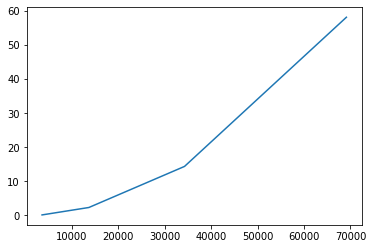

In [8]:
plt.plot(nn,elapsed)

In [6]:
15//3

5

In [7]:
c

NameError: name 'c' is not defined

In [ ]:
points = np.random.random((1000000,3))

In [ ]:
#%%snakeviz
c = mesh.get_tetra(points)

In [ ]:
print(c[1][100])

In [ ]:
from LoopStructural.supports import TetMesh

In [ ]:
boundary_points = np.array([[0,0,0],[1,1,1]])
tmesh = TetMesh()
tmesh.setup_mesh(boundary_points,n_tetra = 200000)

In [ ]:
tmesh.elements_for_array(points)